In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [4]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "Virny":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /home/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/Virny


# One Run One Model Interface Usage

In this example, we are going to audit 4 models for stability and fairness, visualize metrics, and create an analysis report. To get better analysis accuracy, we will use `compute_model_metrics_with_config` interface that will make multiple runs per model. For that, we will need to do next steps:

* Initialize input variables

* Compute subgroup metrics

* Make group metrics composition

* Create metrics visualizations and an analysis report

## Import dependencies

In [5]:
import os
import pandas as pd
from datetime import datetime, timezone

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from virny.user_interfaces.metrics_computation_interfaces import compute_model_metrics_with_config
from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.custom_classes.base_dataset import BaseDataset
from virny.configs.constants import ReportType

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* A **config yaml** that is a file with configuration parameters for different user interfaces for metrics computation.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits of multiple models for one or multiple runs and analyze different types of models.

### Create a Dataset class

Based on the BaseDataset class, your **dataset class** should include the following attributes:
* **Obligatory attributes**: dataset, target, features, numerical_columns, categorical_columns

* **Optional attributes**: X_data, y_data, columns_with_nulls

For more details, please refer to the library documentation.

In [6]:
class CompasDataset(BaseDataset):
    """
    Dataset class for COMPAS dataset that contains sensitive attributes among feature columns.

    Parameters
    ----------
    dataset_path
        Path to a dataset file

    """
    def __init__(self, dataset_path: str):
        df = pd.read_csv(dataset_path)

        int_columns = ['recidivism', 'age', 'age_cat_25 - 45', 'age_cat_Greater than 45',
                       'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M', 'sex']
        int_columns_dct = {col: "int" for col in int_columns}
        df = df.astype(int_columns_dct)

        target = 'recidivism'
        numerical_columns = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
        categorical_columns = ['race', 'age_cat_25 - 45', 'age_cat_Greater than 45',
                               'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M', 'sex']
        features = numerical_columns + categorical_columns

        super().__init__(
            pandas_df=df,
            features=features,
            target=target,
            numerical_columns=numerical_columns,
            categorical_columns=categorical_columns,
        )

In [9]:
dataset = CompasDataset(dataset_path=os.path.join('virny', 'datasets', 'COMPAS.csv'))
dataset.X_data[dataset.X_data.columns[:6]].head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race
0,25,0.0,-2.340451,1.0,-15.010999,African-American
1,26,0.0,0.000000,0.0,0.000000,Caucasian
2,21,0.0,0.000000,0.0,0.000000,Caucasian
3,29,0.0,0.000000,0.0,6.000000,African-American
4,40,0.0,0.000000,0.0,7.513697,Caucasian


### Create a config object

`compute_model_metrics_with_config` interface requires that your **yaml file** includes the following parameters:

* **dataset_name**: a name of your dataset; it will be used to name files with metrics.

* **test_set_fraction**: the fraction from the whole dataset in the range [0.0 - 1.0] to create a test set.

* **bootstrap_fraction**: the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **n_estimators**: the number of estimators for bootstrap to compute subgroup variance metrics.

* **runs_seed_lst**: a list of seeds for each run; the number of runs is derived based on the length of this list. For example, if your runs_seed_lst is [100, 200], this means that for the first run, the interface will use 100 seed, and the code logic will increment this seed for each model (101 for the first model in models_config, 102 for the second model, etc.).

* **sensitive_attributes_dct**: a dictionary where keys are sensitive attribute names (including attribute intersections), and values are privileged values for these attributes. Currently, the library supports only intersections among two sensitive attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify privileged values for intersectional groups since they will be derived from privileged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.


In [10]:
ROOT_DIR = os.path.join('docs', 'examples')
config_yaml_path = os.path.join(ROOT_DIR, 'experiment_compas_config.yaml')
config_yaml_content = """
dataset_name: COMPAS
test_set_fraction: 0.2
bootstrap_fraction: 0.8
n_estimators: 100
sensitive_attributes_dct: {'sex': 0, 'race': 'Caucasian', 'sex&race': None}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [11]:
config = create_config_obj(config_yaml_path=config_yaml_path)
SAVE_RESULTS_DIR_PATH = os.path.join(ROOT_DIR, 'results',
                                     f'{config.dataset_name}_Metrics_{datetime.now(timezone.utc).strftime("%Y%m%d__%H%M%S")}')

### Create a models config

**models_config** is a Python dictionary, where keys are model names and values are initialized models for analysis

In [12]:
models_config = {
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion='gini',
                                                     max_depth=20,
                                                     max_features=0.6,
                                                     min_samples_split=0.1),
    'LogisticRegression': LogisticRegression(C=1,
                                             max_iter=50,
                                             penalty='l2',
                                             solver='newton-cg'),
}

## Subgroup Metrics Computation

After the variables are input to a user interface, the interface creates a **generic pipeline** based on the input dataset class to hide preprocessing complexity and provide handy attributes and methods for different types of model analysis. Later this generic pipeline is used in subgroup analyzers that compute different sets of metrics. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Statistical Bias Analyzer**, but it is easily extensible to any other analyzers. When the variance and bias analyzers complete metrics computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [13]:
metrics_df = compute_model_metrics_with_config(models_config['DecisionTreeClassifier'], 'DecisionTreeClassifier', dataset,
                                               config, SAVE_RESULTS_DIR_PATH, save_results=True, debug_mode=False)

Model random_state:  562
Baseline X_train shape:  (4222, 12)
Baseline X_test shape:  (1056, 12)




2023-02-03 01:33:38 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/100 [00:00<?, ?it/s]

2023-02-03 01:33:39 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-02-03 01:33:41 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics


Look at several columns in top rows of computed metrics

In [14]:
metrics_df[metrics_df.columns[:6]].head(20)

,Metric,overall,sex_priv,sex_dis,race_priv,race_dis
0,Mean,0.526250,0.617604,0.504110,0.598298,0.481964
1,Std,0.095973,0.113321,0.091769,0.095657,0.096168
2,IQR,0.122872,0.149521,0.116413,0.121284,0.123848
3,Entropy,0.246792,0.262124,0.000000,0.216290,0.265541
4,Jitter,0.156582,0.165226,0.154487,0.137100,0.168557
5,Per_Sample_Accuracy,0.652983,0.635874,0.657129,0.660896,0.648119
6,Label_Stability,0.783239,0.773301,0.785647,0.811443,0.765902
7,TPR,0.623218,0.366197,0.666667,0.440000,0.703812
8,TNR,0.711504,0.807407,0.681395,0.809524,0.632588
9,PPV,0.652452,0.500000,0.671463,0.578947,0.676056


## Group Metrics Composition

**Metrics Composer** is responsible for this second stage of the model audit. Currently, it computes our custom group statistical bias and variance metrics, but extending it for new group metrics is very simple. We noticed that more and more group metrics have appeared during the last decade, but most of them are based on the same subgroup metrics. Hence, such a separation of subgroup and group metrics computation allows one to experiment with different combinations of subgroup metrics and avoid subgroup metrics recomputation for a new set of grouped metrics.

In [21]:
models_metrics_dct = read_model_metric_dfs(SAVE_RESULTS_DIR_PATH, model_names=['DecisionTreeClassifier'])

In [16]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [17]:
models_composed_metrics_df = metrics_composer.compose_metrics()

In [19]:
models_composed_metrics_df.head(20)

,Metric,sex,race,sex&race,Model_Name
0,Equalized_Odds_TPR,0.300469,0.263812,0.566284,DecisionTreeClassifier
1,Equalized_Odds_FPR,0.126012,0.176936,0.264831,DecisionTreeClassifier
2,Disparate_Impact,1.355632,1.369810,2.331989,DecisionTreeClassifier
3,Statistical_Parity_Impact,0.260463,0.281056,0.601543,DecisionTreeClassifier
4,Accuracy_Parity,0.018778,-0.001917,0.033701,DecisionTreeClassifier
5,Label_Stability_Ratio,1.015965,0.943877,0.964887,DecisionTreeClassifier
6,IQR_Parity,-0.033107,0.002564,-0.023123,DecisionTreeClassifier
7,Std_Parity,-0.021552,0.000511,-0.018661,DecisionTreeClassifier
8,Std_Ratio,0.809817,1.005344,0.831795,DecisionTreeClassifier
9,Jitter_Parity,-0.010739,0.031456,0.019176,DecisionTreeClassifier


## Metrics Visualization and Reporting

**Metrics Visualizer** provides metrics visualization and reporting functionality. It unifies different preprocessing methods for result metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the Metrics Visualizer class and get custom plots for diverse metrics analysis. Additionally, these plots could be collected in an HTML report with comments for user convenience and future reference.

In [23]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=['DecisionTreeClassifier'],
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

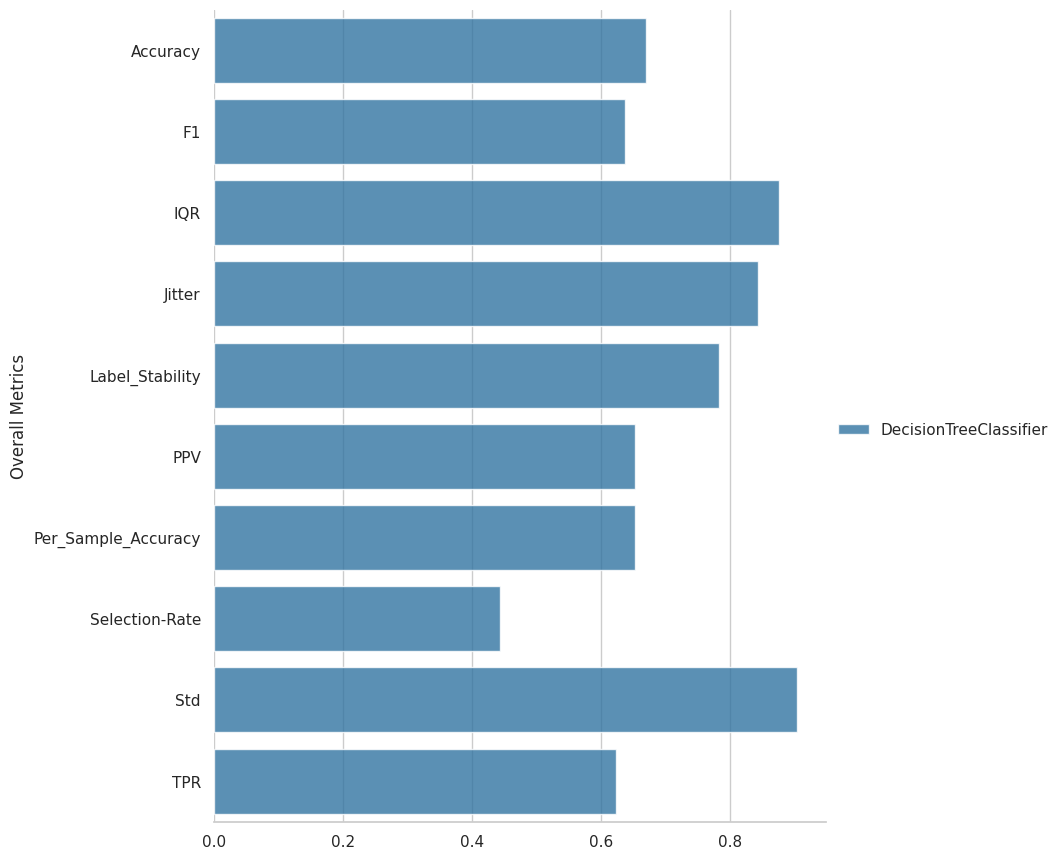

In [24]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                   'Per_Sample_Accuracy', 'Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Overall Metrics"
)